In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torchvision import datasets

In [2]:
vgg = torchvision.models.vgg16()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [4]:
train_image_path = "/home/max/Desktop/eight_type/train/"
val_image_path = "/home/max/Desktop/galaxy_image/eight_type/validation/"
test_image_path = "/home/max/Desktop/galaxy_image/eight_type/test/"
gz2_path = "/home/max/Desktop/images_gz2/"

In [5]:
batch_size = 16
train_trans = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
#                                     transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()
                                  ])

train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, pin_memory = True, batch_size = batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

gz2_trans = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
gz2_data = ImageFolder(gz2_path, transform = test_trans)
gz2_loader = DataLoader(gz2_data, batch_size=batch_size)

print('Train:', len(train_data))
print('Valid:', len(val_data))
print('Test:', len(test_data))
print('Galaxy zoo 2:', len(gz2_data))

Train: 3186
Valid: 145
Test: 145
Galaxy zoo 2: 243434


In [6]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
path_data = ImageFolderWithPaths(gz2_path)
data_loader = DataLoader(path_data)

tensor([5, 3, 7, 7, 0, 7, 6, 2, 1, 5, 2, 2, 2, 7, 7, 7])


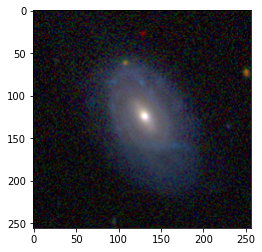

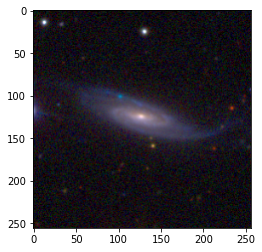

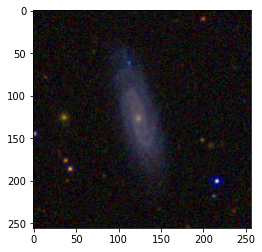

In [7]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
#     print(images[i])
    plt.figure(i)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()

In [8]:
256 * 28 * 28

200704

In [9]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
#         nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
#         ## CNN5
#         nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(256 * 28 * 28, 512), # Fully-connected layer
        nn.Dropout(0.5), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(512, 128),
#         nn.Dropout(0.1),
        nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.Dropout(0.5),
#         nn.ReLU(),
    )
    self.out = nn.Linear(128, 8)
    
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    output = self.out(x)
    return output, x

In [10]:
512 * 7 * 7

25088

In [11]:
# model = Galaxy()
model = torchvision.models.vgg16(pretrained=False)
# model = torchvision.models.resnet18(pretrained=False)
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [13]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
# l1_crit = nn.L1Loss(size_average=False)
# factor = 0.03
n_epochs = 50
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for x, y in tqdm(train_loader):
#         print(x.shape)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
#         print(x.shape)
        prediction = model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
#         print(prediction.shape)
#         print(y.shape)
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
        
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss.cpu().detach().numpy())
    train_acc_record.append(train_acc.cpu().detach().numpy())

    model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        reg_loss = 0

#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model, 'eight_loop.pkl')
        print('save model')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss.cpu().detach().numpy())
    val_acc_record.append(val_acc.cpu().detach().numpy())
    
    ## semi-supervised
    
#     with torch.no_grad():
#         # model = torch.load('eight.pkl')
#         galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
#         loss_func = nn.CrossEntropyLoss()
#         i = 0
#         store = []
#         galaxy_type_to = []
#         for x, y in tqdm(gz2_loader):
#             i += 1
#             if train_on_gpu:
#                 x, y = x.cuda(), y.cuda()
#             output = model(x)/100
# #             output = output.cpu().numpy()
# #             print(output[0])
#             out = output.argmax(dim = 1).cpu().numpy()
# #             print(out[0])
# #             print(output[0][out][0])
#             if output[0][out[0]] >= 0.35:
#                 store.append(path_data[i-1][2].split('/')[6])
#                 print(path_data[i-1][2].split('/')[6])
#                 out = out.to('cpu').numpy()
#             #     ans = galaxy_type[y[0]]
#                 pre = galaxy_type[out[0]]
#                 galaxy_type_to.append(pre)
#                 x = x.squeeze()
#                 x = x.to('cpu')
#         print(f'Finish filter [ {epoch+1}/{n_epochs} ]')
#         with open('/home/max/Desktop/loop.txt', 'a+') as file:
#             for (i, j) in zip(store, galaxy_type_to):
#         #         print(i)
#                 file.write(i)
#                 file.write(' ')
#                 file.write(j)
#                 file.write('\n')
    
# # torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/200 [00:00<?, ?it/s]

/home/max/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 1/50 ] loss = 3.86870, acc = 0.11375


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 1/50 ] loss = 2.14587, acc = 0.13793


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 2/50 ] loss = 2.21024, acc = 0.12594


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 2/50 ] loss = 2.14523, acc = 0.13793


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 3/50 ] loss = 2.17637, acc = 0.13594


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 3/50 ] loss = 2.11658, acc = 0.13793


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 4/50 ] loss = 2.15081, acc = 0.13531


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 4/50 ] loss = 2.15522, acc = 0.10345


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 5/50 ] loss = 2.12409, acc = 0.14750


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 5/50 ] loss = 2.05299, acc = 0.16552


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 6/50 ] loss = 1.96463, acc = 0.20813


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 6/50 ] loss = 2.04255, acc = 0.26207


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 7/50 ] loss = 1.85765, acc = 0.25469


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 7/50 ] loss = 1.98846, acc = 0.24138


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 8/50 ] loss = 1.81181, acc = 0.26875


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 8/50 ] loss = 1.70636, acc = 0.36552


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 9/50 ] loss = 1.72127, acc = 0.30500


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 9/50 ] loss = 1.81260, acc = 0.30345


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 10/50 ] loss = 1.66865, acc = 0.31688


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 10/50 ] loss = 1.58538, acc = 0.37241


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 11/50 ] loss = 1.61759, acc = 0.33719


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 11/50 ] loss = 1.57789, acc = 0.38621


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 12/50 ] loss = 1.54178, acc = 0.35313


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 12/50 ] loss = 1.51272, acc = 0.35172


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 13/50 ] loss = 1.51583, acc = 0.38875


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 13/50 ] loss = 1.62703, acc = 0.36552


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 14/50 ] loss = 1.51883, acc = 0.36781


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 14/50 ] loss = 1.49910, acc = 0.33103


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 15/50 ] loss = 1.51251, acc = 0.38562


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 15/50 ] loss = 1.72398, acc = 0.32414


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 16/50 ] loss = 1.49011, acc = 0.38375


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 16/50 ] loss = 1.53493, acc = 0.41379


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 17/50 ] loss = 1.46662, acc = 0.39563


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 17/50 ] loss = 1.50631, acc = 0.39310


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 18/50 ] loss = 1.42616, acc = 0.41938


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 18/50 ] loss = 1.50623, acc = 0.41379


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 19/50 ] loss = 1.45984, acc = 0.38719


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 19/50 ] loss = 1.78171, acc = 0.26897


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 20/50 ] loss = 1.42183, acc = 0.40156


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 20/50 ] loss = 1.48193, acc = 0.43448


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 21/50 ] loss = 1.40152, acc = 0.42750


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 21/50 ] loss = 1.43897, acc = 0.43448


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 22/50 ] loss = 1.40067, acc = 0.41625


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 22/50 ] loss = 1.51397, acc = 0.34483


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 23/50 ] loss = 1.38675, acc = 0.42750


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 23/50 ] loss = 1.37710, acc = 0.45517


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 24/50 ] loss = 1.38027, acc = 0.42469


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 24/50 ] loss = 1.47457, acc = 0.42759


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 25/50 ] loss = 1.34242, acc = 0.44188


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 25/50 ] loss = 1.38694, acc = 0.48276


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 26/50 ] loss = 1.35996, acc = 0.43000


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 26/50 ] loss = 1.46936, acc = 0.37241


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 27/50 ] loss = 1.33567, acc = 0.43719


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 27/50 ] loss = 1.38123, acc = 0.40690


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 28/50 ] loss = 1.32456, acc = 0.46063


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 28/50 ] loss = 1.42276, acc = 0.40000


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 29/50 ] loss = 1.29556, acc = 0.47063


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 29/50 ] loss = 1.40446, acc = 0.40690


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 30/50 ] loss = 1.29206, acc = 0.46469


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 30/50 ] loss = 1.48199, acc = 0.38621


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 31/50 ] loss = 1.28693, acc = 0.46750


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 31/50 ] loss = 1.42614, acc = 0.45517


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 32/50 ] loss = 1.26410, acc = 0.47938


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 32/50 ] loss = 1.42381, acc = 0.39310


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 33/50 ] loss = 1.25584, acc = 0.49094


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 33/50 ] loss = 1.38679, acc = 0.45517


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 34/50 ] loss = 1.24715, acc = 0.49250


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 34/50 ] loss = 1.32083, acc = 0.40000


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 35/50 ] loss = 1.23918, acc = 0.49219


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 35/50 ] loss = 1.35801, acc = 0.44138


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 36/50 ] loss = 1.21554, acc = 0.49094


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 36/50 ] loss = 1.45685, acc = 0.40690


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 37/50 ] loss = 1.21129, acc = 0.50969


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 37/50 ] loss = 1.40190, acc = 0.35862


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 38/50 ] loss = 1.21125, acc = 0.50406


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 38/50 ] loss = 1.33944, acc = 0.44828


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 39/50 ] loss = 1.17880, acc = 0.51281


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 39/50 ] loss = 1.34078, acc = 0.43448


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 40/50 ] loss = 1.20799, acc = 0.51094


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 40/50 ] loss = 1.37044, acc = 0.48276


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 41/50 ] loss = 1.15499, acc = 0.52563


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 41/50 ] loss = 1.42238, acc = 0.42759


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 42/50 ] loss = 1.19636, acc = 0.50813


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 42/50 ] loss = 1.26640, acc = 0.46897


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 43/50 ] loss = 1.14484, acc = 0.53719


  0%|          | 0/145 [00:00<?, ?it/s]

save model
[ Validation | 43/50 ] loss = 1.25074, acc = 0.45517


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 44/50 ] loss = 1.14901, acc = 0.52688


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 44/50 ] loss = 1.50954, acc = 0.44138


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 45/50 ] loss = 1.12101, acc = 0.55906


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 45/50 ] loss = 1.36742, acc = 0.42069


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 46/50 ] loss = 1.10645, acc = 0.56031


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 46/50 ] loss = 1.30686, acc = 0.46897


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 47/50 ] loss = 1.10333, acc = 0.56250


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 47/50 ] loss = 1.39858, acc = 0.47586


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 48/50 ] loss = 1.04588, acc = 0.58594


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 48/50 ] loss = 1.29701, acc = 0.49655


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 49/50 ] loss = 1.04257, acc = 0.58750


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 49/50 ] loss = 1.28857, acc = 0.44828


  0%|          | 0/200 [00:00<?, ?it/s]

[ Train | 50/50 ] loss = 0.98408, acc = 0.61125


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 50/50 ] loss = 1.31931, acc = 0.53103


In [14]:
!nvidia-smi

Sun Oct 17 17:19:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 51%   64C    P2   193W / 200W |   5860MiB /  7973MiB |     76%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in val_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

[ Test ] loss = 1.31931, acc = 0.53103


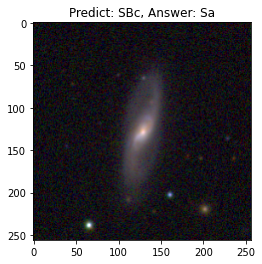

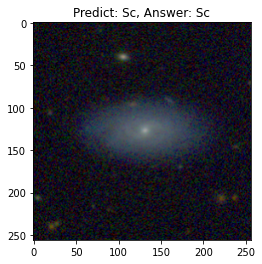

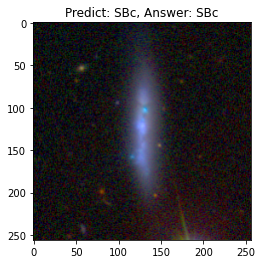

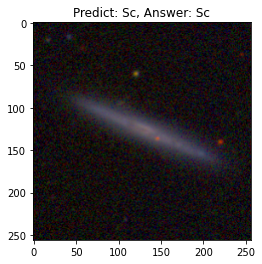

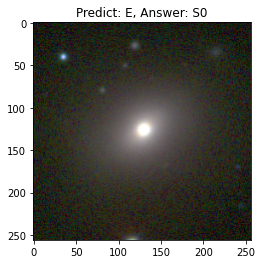

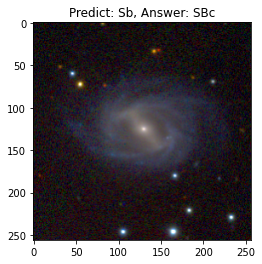

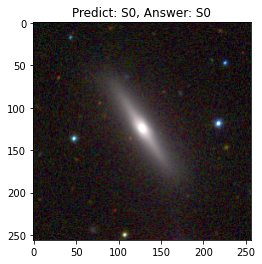

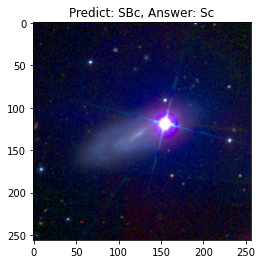

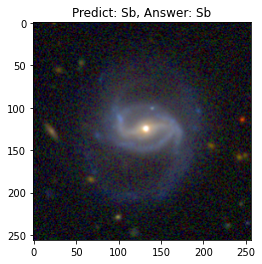

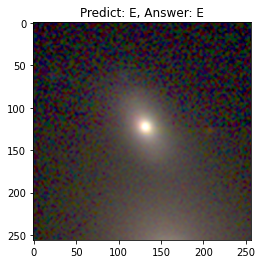

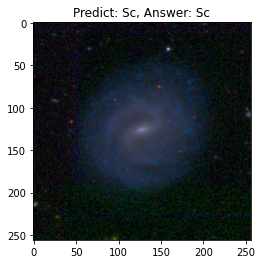

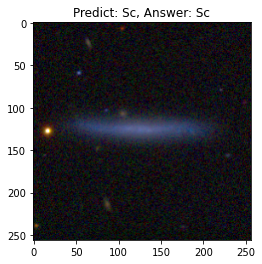

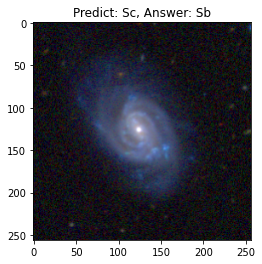

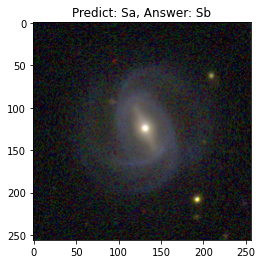

In [16]:
model = torch.load('eight_loop.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in val_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

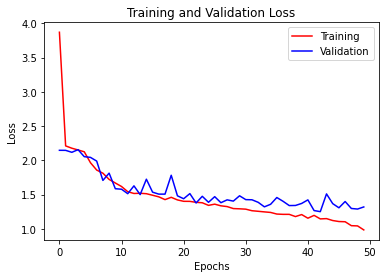

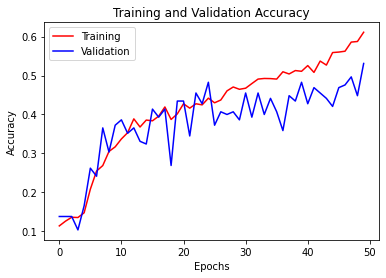

In [17]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [18]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

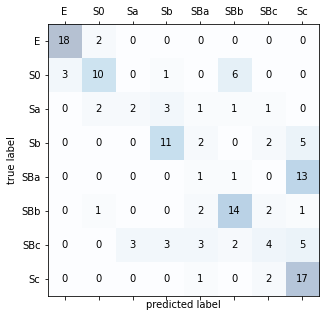

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()